# Photon ID Run 2 BDT classification

In [1]:
import uproot
import numpy as np
import pandas as pd
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
#import mplhep as hep
#hep.style.use("ATLAS")

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

import joblib

import seaborn as sns

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/"
savedir = "/home/chardong/y_identification/Venv/save_plots/Py8_yj_jj_train_skim30/"
#datadir = "/eos/user/m/mdelmast/Data/EGamma/PhotonID/Run2/"
savedirmodel = "/home/chardong/y_identification/Venv/BDT_model/"

In [3]:
#totald = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w.pkl")
#totald = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w_skim.pkl")
totald = pd.read_pickle(datadir+"RAW_data/Py8_yj_jj_mc16ade_pd122_train_w_skim_30.pkl")

In [4]:
shower_shape_var = ['y_Reta',
                    'y_Rphi',
                    'y_weta2',
                    'y_fracs1',
                    'y_weta1',
                    'y_wtots1',
                    'y_Rhad',
                    'y_Rhad1',
                    'y_Eratio', 
                    'y_deltae']



conv_var = [ 'y_convRadius', 'y_convType']

kinem_var = ['y_pt', 'y_eta', 'y_phi']

#truth_var = ['y_truth_pt', 'y_truth_eta', 'y_truth_pdgId', 'y_truth_mother_pdgId' ]
truth_var = ['y_truth_pt', 'y_truth_eta' ]

discriminating_var = shower_shape_var + kinem_var + conv_var
discriminating_var

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType']

### Prepare inputs for training

* `discriminating_var` containes the features used in the training
* Weights are added Y column to be able to access them after splitting in train and test samples.
* `test_size` represents the proportion of the dataset to include in the test split

In [5]:
set(totald.columns)-set(discriminating_var)

{'evt_mu',
 'truth_label',
 'weight',
 'y_IsLoose',
 'y_IsTight',
 'y_truth_eta',
 'y_truth_pt'}

In [6]:
Y_var = ["truth_label",
         "weight",
         'y_IsTight',
         'y_IsLoose',
         'evt_mu', 
        ]

Y_var

['truth_label', 'weight', 'y_IsTight', 'y_IsLoose', 'evt_mu']

### Save X and Y datasets with relevant variables

* Adding truth variables to X for performance studies, will be removed after splitting

In [7]:
X = totald[discriminating_var+truth_var]
Y = totald[Y_var]

### Split dataset into train, validation and test samples

* Test dataset size: 20 %

In [8]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Split train + validation set into train and validation

* Train and validation are respectively 80% and 20% of 80% of total
* Save weights in separate arrays

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

In [10]:
weight_train = y_train["weight"]
weight_val   = y_val  ["weight"]
weight_test  = y_test ["weight"]

In [11]:
othervars_train = y_train[['evt_mu', 'y_IsLoose', 'y_IsTight']]
othervars_val   = y_val  [['evt_mu', 'y_IsLoose', 'y_IsTight']]
othervars_test  = y_test [['evt_mu', 'y_IsLoose', 'y_IsTight']]

In [12]:
truth_train = x_train[['y_truth_pt','y_truth_eta']]
truth_val   = x_val  [['y_truth_pt','y_truth_eta']]
truth_test  = x_test [['y_truth_pt','y_truth_eta']]

In [13]:
truth_var_drop = list(set(y_train.columns)-{'truth_label'})
truth_var_drop

['weight', 'evt_mu', 'y_IsLoose', 'y_IsTight']

In [14]:
y_train = y_train.drop(truth_var_drop, axis=1)
y_test  = y_test.drop(truth_var_drop, axis=1)
y_val   = y_val.drop(truth_var_drop, axis=1)

In [15]:
x_train = x_train.drop(truth_var, axis=1)
x_test  = x_test.drop(truth_var, axis=1)
x_val   = x_val.drop(truth_var, axis=1)

In [16]:
print('TRAINING   size = {:8d}'.format(len(y_train)))
print('TEST       size = {:8d}'.format(len(y_test)))
print('VALIDATION size = {:8d}'.format(len(y_val)))

TRAINING   size = 11182003
TEST       size =  3494377
VALIDATION size =  2795501


In [17]:
print('Number of signal events in test sample     :', len(y_test.query('truth_label == True')))
print('Number of background events in test sample :', len(y_test.query('truth_label == False')))

Number of signal events in test sample     : 2338410
Number of background events in test sample : 1155967


In [18]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

# BDT training

In [19]:
model = lgb.LGBMClassifier(learning_rate=0.01,  
                           num_leaves=191,
                           max_depth=-93,
                           objective='xentropy',
                           n_estimators=1000,
                           force_col_wise=True)

cb = [lgb.early_stopping(stopping_rounds=10),lgb.log_evaluation(30)]

In [20]:
model.fit(x_train, y_train,
          sample_weight = weight_train,
          eval_set = [(x_train, y_train), (x_val, y_val)],  
          eval_names = ['Train', 'Validation'],
          eval_metric = 'xentropy', 
          eval_sample_weight = [weight_train, weight_val],
          callbacks=cb)

[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 4581780992.000000
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 11182003, number of used features: 15
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1154263936.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.500230 -> initscore = 0.000918
[LightGBM] [Info] Start training from score 0.000918
Training until validation scores don't improve for 10 rounds
[30]	Train's cross_entropy: 0.533896	Validation's cross_entropy: 0.529848
[60]	Train's cross_entropy: 0.432541	Validation's cross_entropy: 0.430482
[90]	Train's cross_entropy: 0.367046	Validation's cross_entropy: 0.366516
[120]	Train's cross_entropy: 0.32323

LGBMClassifier(force_col_wise=True, learning_rate=0.01, max_depth=-93,
               n_estimators=1000, num_leaves=191, objective='xentropy')

In [21]:
 # Saving model to file
joblib.dump(model,'/home/chardong/y_identification/Venv/BDT_model/LGBMClassifier_model_hard_no_loose_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pkl')

['/home/chardong/y_identification/Venv/BDT_model/LGBMClassifier_model_hard_no_loose_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pkl']

In [22]:
# Loading model from file
model = joblib.load(savedirmodel+"/LGBMClassifier_model_hard_no_loose_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pkl")

### Feature importance

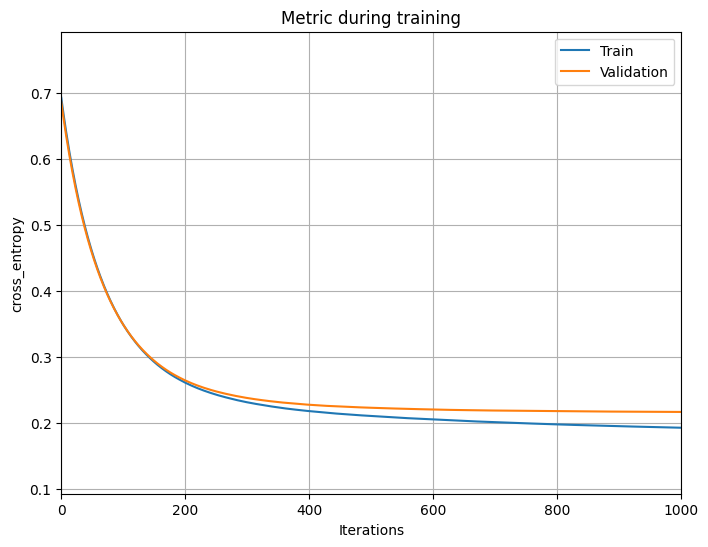

In [23]:
# Cross-entropy evolution during training
lgb.plot_metric(model, figsize=(8,6))
plt.title('Metric during training')
plt.savefig(savedir+'Optuna/metric_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pdf')

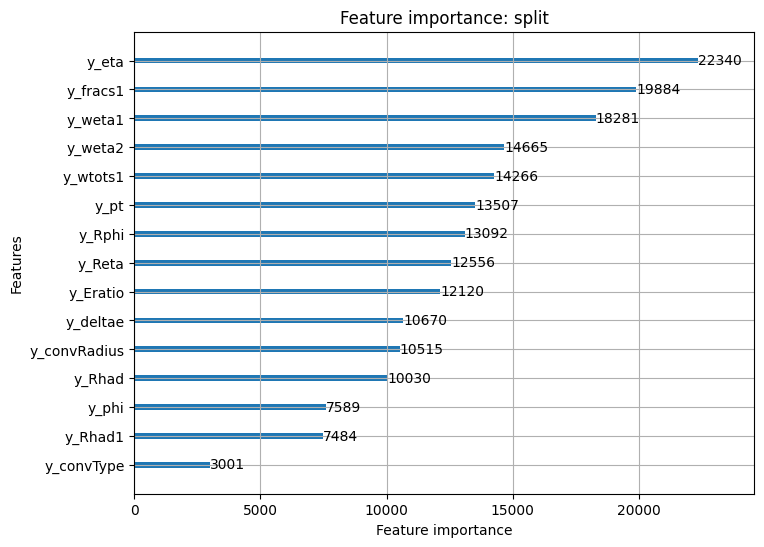

In [24]:
# Feature importance: Numbers of times the feature is used in a model
lgb.plot_importance(model, importance_type='split', figsize=(8,6))
plt.title('Feature importance: split')
plt.savefig(savedir+'Optuna/feature_split_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pdf')
plt.show()

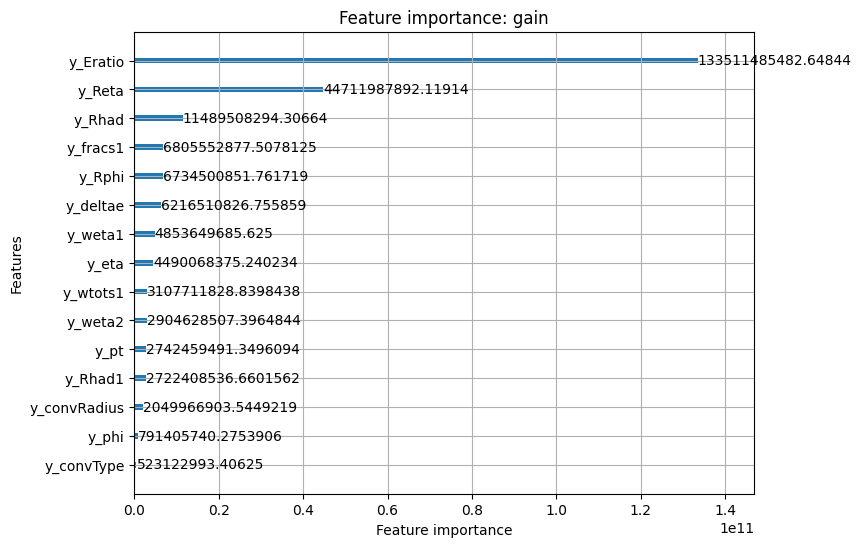

In [25]:
lgb.plot_importance(model, importance_type='gain', precision = None, figsize=(8,6))
plt.title('Feature importance: gain')
plt.savefig(savedir+'Optuna/feature_gain_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pdf')
plt.show()

### Make predictions for test sample, add signal and background scores

In [26]:
y_pred_prob_test = model.predict_proba(x_test)

df_pred_test = pd.DataFrame(y_pred_prob_test, columns=["background_score", "signal_score"])
df_pred_test.reset_index(inplace=True, drop=True)

In [27]:
y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True, drop=True)

truth_test.reset_index(inplace=True, drop=True)

othervars_test.reset_index(inplace=True, drop=True)

df_test_vars = x_test[kinem_var + conv_var]
df_test_vars.reset_index(inplace=True, drop=True)

weight_test = pd.DataFrame(weight_test)
weight_test.reset_index(inplace=True, drop=True)

In [28]:
df_test = pd.concat([df_test_vars,
                     weight_test,
                     y_test,
                     othervars_test,
                     truth_test,
                     df_pred_test,
                    ], axis=1, join='inner', ignore_index=True)

In [29]:
col_names = list(df_test_vars.columns) + \
            list(weight_test.columns) + \
            list(y_test.columns) + \
            list(othervars_test.columns) + \
            list(truth_test.columns) + \
            list(df_pred_test.columns)
df_test.columns = col_names

In [30]:
df_test

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,background_score,signal_score
0,51.956734,2.267797,-1.499033,49.392670,3,48.548934,0.0,31.50,False,False,12.533671,2.266477,0.998277,0.001723
1,34.364429,-1.958636,1.959331,317.343506,1,38.855491,0.0,47.50,False,False,26.214190,-1.961529,0.899300,0.100700
2,39.007401,0.172711,-0.628337,9999.000000,0,554.386153,1.0,29.50,True,True,37.140778,0.202515,0.027844,0.972156
3,86.679977,0.162386,2.113541,9999.000000,0,40.708948,1.0,22.50,True,True,86.595421,0.162440,0.024556,0.975444
4,281.008636,-0.796674,0.281347,9999.000000,0,0.283104,1.0,28.50,True,True,282.742554,-0.796599,0.015910,0.984090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494372,43.406239,1.724553,-0.356645,88.554863,5,34.390531,0.0,43.50,False,False,22.481043,1.724617,0.990979,0.009021
3494373,550.298889,-0.506703,1.353711,9999.000000,0,0.013548,1.0,15.50,True,True,546.056641,-0.506655,0.014745,0.985255
3494374,174.141190,0.462812,2.917594,9999.000000,0,2.829482,1.0,31.50,True,True,176.855133,0.462957,0.015591,0.984409
3494375,280.226105,1.251904,-2.007665,673.256714,2,0.306223,1.0,28.49,True,True,284.577698,1.252312,0.046822,0.953178


In [31]:
df_test.to_pickle(datadir+"/df_test_sample_hard_scattering/df_test_sample_hard_scattering_skim30_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pkl")

### BDT output

The BDT output has two columns: for each event a score (probability) to belong to class 0 or class 1  (here they are called `background_class` and `signal_class` ) is assigned.

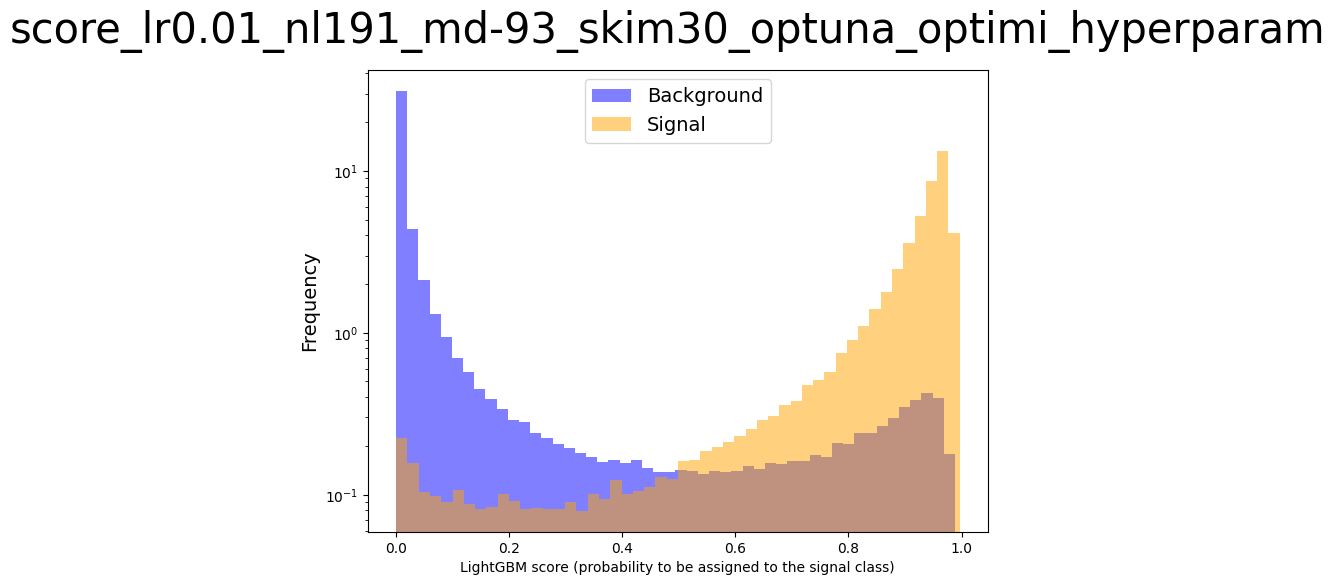

In [32]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(df_test[(df_test["truth_label"]==0 )]["signal_score"],
         weights = df_test[(df_test["truth_label"]==0 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5, 
         histtype = 'stepfilled', label='Background', color = 'b')

plt.hist(df_test[(df_test["truth_label"]==1 )]["signal_score"],
         weights = df_test[(df_test["truth_label"]==1 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5,
         histtype = 'stepfilled', label='Signal', color = 'orange')

plt.ylabel('Frequency', fontsize = 14)

plt.legend(loc='upper center', fontsize = 14)
plt.gca().set(xlabel="LightGBM score (probability to be assigned to the signal class)")

fig.suptitle('score_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam', fontsize=30)
plt.savefig(savedir+'Optuna/score_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pdf')
plt.show()

### ROC curve

1) compute signal and background efficiencies for "official" cut-based Tight selection

In [33]:
s_tot = sum( df_test[(df_test["truth_label"] == 1)]["weight"] )
s_selected = sum( df_test[(df_test["truth_label"] == 1) & (df_test['y_IsTight'].values)]["weight"] )
s_eff = s_selected / s_tot

b_tot = sum( df_test[(df_test["truth_label"] == 0)]["weight"] )
b_selected = sum( df_test[(df_test["truth_label"] == 0) & (df_test['y_IsTight'].values)]["weight"] )
b_eff = b_selected / b_tot

In [34]:
print(f"Number of signal events                   = {s_tot:12.0f}")
print(f"Number of signal events passing Tight     = {s_selected:12.0f}")
print(f"Signal efficiency of cut-based Tight      = {100.*s_selected/s_tot:11.2f}%" )
print()
print(f"Number of background events               = {b_tot:12.0f}")
print(f"Number of background events passing Tight = {b_selected:12.0f}")
print(f"Background efficiency of cut-based Tight  = {100.*b_selected/b_tot:11.2f}%" )
print(f"Background rejection of cut-based Tight   = {100.*(1-b_selected/b_tot):11.2f}%" )

Number of signal events                   =    722080289
Number of signal events passing Tight     =    579900633
Signal efficiency of cut-based Tight      =       80.31%

Number of background events               =    721046049
Number of background events passing Tight =     45635422
Background efficiency of cut-based Tight  =        6.33%
Background rejection of cut-based Tight   =       93.67%


2) Plot ROC curve of trained BDT with weighted events, compare to current cut-based Tight selection 

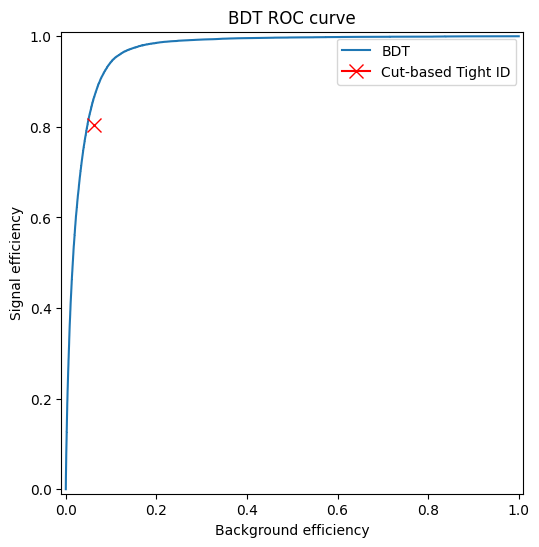

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

mod_disp = RocCurveDisplay.from_estimator(model, x_test, y_test, sample_weight=weight_test, 
                                          label="BDT", ax=ax) 

plt.plot(b_eff, s_eff, marker="x", markersize=10, color="red", label = 'Cut-based Tight ID')

plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')

#plt.xlim([0.0, 0.15])
#plt.ylim([0.65, 1.0])
#plt.title('BDT ROC curve - zoom')

plt.title('BDT ROC curve')
plt.legend()

plt.savefig(savedir+'Optuna/ROC_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pdf')
plt.show()

### Correlation between input variables

In [36]:
#x_train_sel = x_train.query('y_wtots1 >- 800 & y_weta1 > -800')
#x_train_sel.reset_index(inplace=True, drop=True)

In [37]:
corr = x_train.corr()

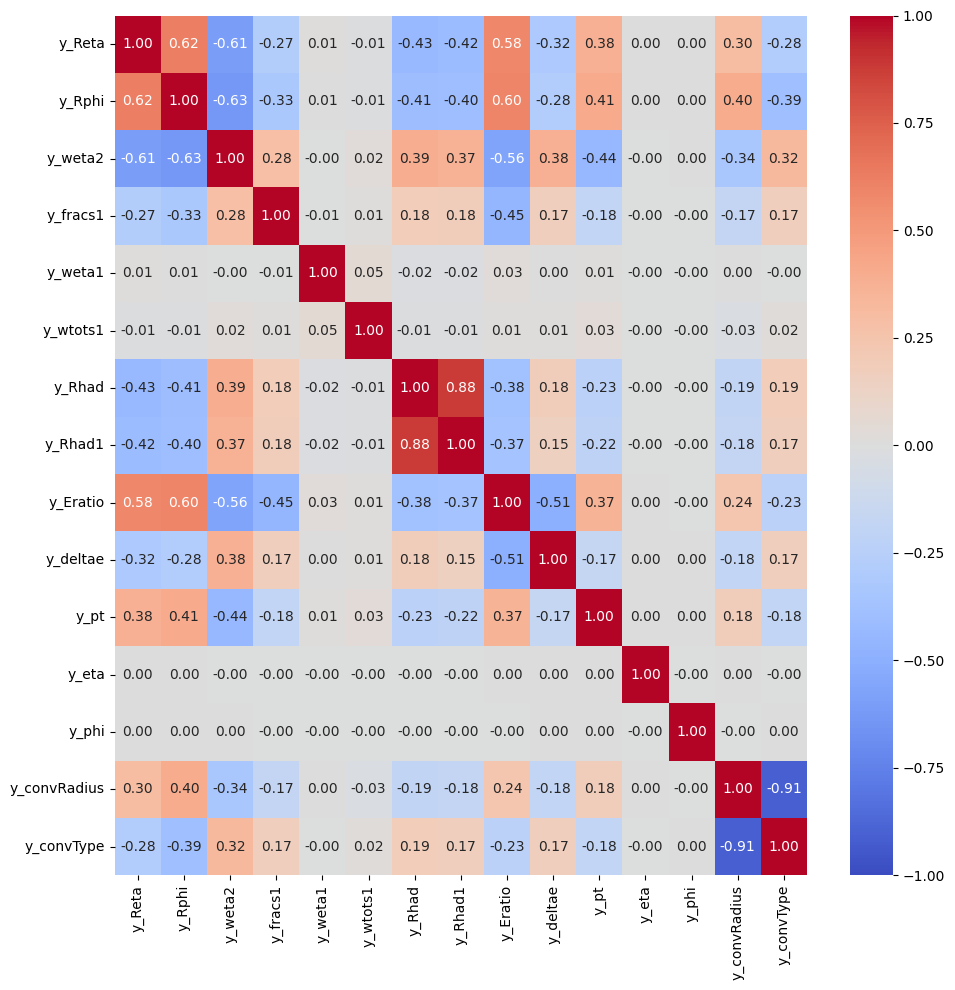

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
plt.savefig(savedir+'Optuna/correlations_train_sample_all_lr0.01_nl191_md-93_skim30_optuna_optimi_hyperparam.pdf')
plt.show()

In [39]:
#corr_sig = x_train[(y_train==1)].corr()
#corr_bkg = x_train[(y_train==0)].corr()